### Load Factor Prediction Model

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer


#### Dataset
In the data folder of this project we build up a dataset of windfarms across the country at different dates and compared a set of weather factors to the load factor at that point in time.

We want to build a model that given some weather attributes (forecast or current) can accurately predict the percentage of the max generation capacity the wind farm will be generating (load factor). 

In [2]:
dataset = pd.read_csv('../Data/CurrentDataset.csv')


dataset['wgust'].replace('', np.nan, inplace=True)
dataset = dataset.dropna().drop('Unnamed: 0',axis=1)
dataset = dataset[dataset['loadFactor']<=1]
y = dataset['loadFactor']
X = dataset.drop('BMUID',axis=1).drop('loadFactor',axis=1)
print(y.shape)
print(X.shape)

print(y.mean())

print(dataset.describe())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)



(4579,)
(4579, 9)
0.36511733409761943
              temp         wspd        wgust  sealevelpressure   visibility  \
count  4579.000000  4579.000000  4579.000000       4579.000000  4579.000000   
mean      7.734440    12.929155    24.571610       1007.831382    18.677681   
std       4.585739     6.488408    19.359959         15.405495     8.254311   
min      -3.800000     0.000000     0.000000        952.700000     0.100000   
25%       4.200000     7.900000     8.100000        997.300000    12.200000   
50%       7.300000    12.400000    22.700000       1009.000000    18.900000   
75%      11.200000    17.100000    36.450000       1018.100000    24.900000   
max      21.200000    49.000000   114.100000       1050.100000    46.600000   

        cloudcover       precip          dew     humidity   loadFactor  
count  4579.000000  4579.000000  4579.000000  4579.000000  4579.000000  
mean     54.120856     0.094514     4.741013    82.379775     0.365117  
std      26.932755     1.552351

#### Approaches

##### Linear Regression

In [3]:
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


Visualise correlation between different variables of the dataset - highlights wspd most important factor and dew is very unimportant, also shows a potential correlation between low pressure and high loadfactor.

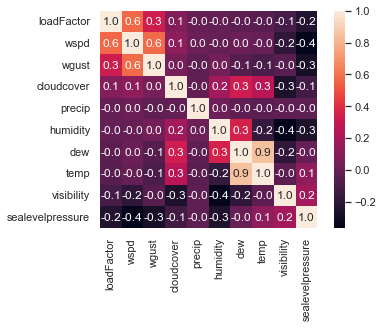

In [4]:

correlation = dataset.corr(method='pearson')
columns = correlation.nlargest(10, 'loadFactor').index

correlation_map = np.corrcoef(dataset[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True,
                      fmt='.1f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()


From this we can adjust the data a bit more and then evaluate a range of different models.
Below we scale & standardize the features, before running an evaluation of a set of different models to determine which performs best in our use case.
We here evaluate both linear and nonlinear models.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

print("Linear Models:\n")

potentialLinearModels = [
    ('Linear Regression', LinearRegression()),
    ('Lasso', LassoCV()),
    ('ElasticNet', ElasticNet()),
    ('SGDRegressor', SGDRegressor()),
    ('SVM', SVR())
]

results = []
names = []
for name, model in potentialLinearModels:
    pipeline = Pipeline(
        steps=[('preprocessor', scaler), ('classifier', model)])
    kfold = KFold(n_splits=30)
    cv_results = cross_val_score(
        pipeline, X_train, y_train, cv=kfold)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))


print("\nNon-linear Models:\n")


potentialNonLinearModels = [
    ('DecisionTree Regressor', DecisionTreeRegressor()),
    ('KNN Regressor', KNeighborsRegressor()),
    ('GradBoost Regressor', GradientBoostingRegressor()),
    ('ADABoost Regressor', AdaBoostRegressor()),
    ('MLP Regressor', MLPRegressor())
]


results = []
names = []
for name, model in potentialNonLinearModels:
    pipeline = Pipeline(steps=[('preprocessor', Normalizer()),('preprocessor2', StandardScaler()), ('regressor', model)])
    kfold = KFold(n_splits=5)
    cv_results = cross_val_score(
        pipeline, X_train, y_train, cv=kfold,)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))


Linear Models:

Linear Regression: 0.314504 (0.096753)
Lasso: 0.315553 (0.094629)
ElasticNet: -0.007706 (0.010839)
SGDRegressor: 0.313332 (0.096028)
SVM: 0.356322 (0.099961)

Non-linear Models:

DecisionTree Regressor: -0.080569 (0.034712)
KNN Regressor: 0.295129 (0.038427)
GradBoost Regressor: 0.378528 (0.045941)
ADABoost Regressor: 0.313703 (0.029072)
MLP Regressor: 0.352700 (0.053688)


Another common library is XGBoost which is not in the SKlearn package. We will see if this gradient boosting approach works better. And also run gridsearch to find optimal hyperparams

In [5]:
import xgboost as xgb
#XGB
X_scaled = Normalizer().fit_transform(StandardScaler().fit_transform(X))
# data_dmatrix = xgb.DMatrix(data=X_scaled,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.4, learning_rate = 0.01,
                max_depth = 200, alpha = 0.95, n_estimators = 1000)

xg_reg.fit(X_train,y_train)

y_pred = xg_reg.predict(X_test)

print((y_test-y_pred).abs().mean(),(y_test-y_pred).abs().std())


0.17249015994487268 0.14428414706961562


In [6]:
from sklearn.model_selection import GridSearchCV

# Model Definitions
MLP_pipeline = Pipeline(
    steps=[('preprocessor', scaler), ('regressor', MLPRegressor())])

# Parameter Grids
param_grid_MLP = {'regressor__max_iter': [200,300,500],
                  'regressor__solver': ['adam'],
                  'regressor__alpha': [0.0001,0.0005,0.001],
                  'regressor__learning_rate': ['constant', 'adaptive'],
                  'regressor__learning_rate_init': [0.0001, 0.001, 0.01],
                  'regressor__hidden_layer_sizes':[(100,100,500,500,100,100)]
                  }

param_grid_grad_boost = {}

# Grid function definitions
grid_MLP = GridSearchCV(MLP_pipeline, param_grid_MLP,
                        verbose=3, refit=True, n_jobs=-1)

#Solve:
# grid_MLP.fit(X_train,y_train)
# print(grid_MLP.best_params_)
# print(grid_MLP.best_score_)


In [7]:
from sklearn.model_selection import GridSearchCV
GradBoost_pipeline = Pipeline(
    steps=[('preprocessor', StandardScaler()), ('regressor',
                                      GradientBoostingRegressor())])

param_grid_grad_boost = {
    'regressor__learning_rate':[0.1,0.01,0.001],
    'regressor__alpha':[0.9,0.95],
    'regressor__max_depth':[3,4,5,6],
    'regressor__n_estimators':[100,150,200],
    'regressor__criterion':['friedman_mse', 'squared_error', 'mse'],
    'regressor__loss':['squared_error', 'absolute_error', 'huber', 'quantile']
}

grid_gradBoost = GridSearchCV(GradBoost_pipeline,
                              param_grid_grad_boost,
                              verbose=2,
                              refit=True,
                              n_jobs=-1,
                              scoring='neg_root_mean_squared_error')

grid_gradBoost.fit(X_train, y_train)
print(grid_gradBoost.best_params_)
print(grid_gradBoost.best_score_)


Fitting 5 folds for each of 864 candidates, totalling 4320 fits


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

MLP_model = Pipeline(steps=[('preprocessor', StandardScaler()), ('regressor',MLPRegressor())])
                                      #MLPRegressor(alpha=0.0005,hidden_layer_sizes=(100,100,100,100,100),learning_rate='constant',learning_rate_init=0.0001,solver='adam')
MLP_model.fit(X_train,y_train)

y_pred = MLP_model.predict(X_test)


print('MLP:')
print((y_test-y_pred).abs().mean(),(y_test-y_pred).abs().std())


gradBoost_model = Pipeline(steps=[('preprocessor', StandardScaler()), ('regressor',GradientBoostingRegressor(max_depth=50,loss='huber',learning_rate=0.1,criterion='mse',alpha=0.65,n_estimators=500))])
                                     
gradBoost_model.fit(X_train,y_train)
y_pred = gradBoost_model.predict(X_test)


print('Grad:')
print((y_test-y_pred).abs().mean(),(y_test-y_pred).abs().std())

MLP:
0.19172581976628109 0.14504162473025167


Here we see some not ideal performance results and we find that when using our test dataset, the best scoring models (MLP,gradBoost) achieve roughly 0.17% mean error, and .13% standard deviation.


Our next approach is to attempt to use keras and tensorflow to build a deeper model to see if this shows any improvements in the system. We find that these at best perform around the as our best non-deeplearning based models so will focus on tuning hyperparamters to get a better result from those instead.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from matplotlib import pyplot

def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(50, input_dim=9, kernel_initializer='normal',kernel_regularizer='l2', activation='relu'))
	model.add(Dense(100, input_dim=50, kernel_initializer='normal',kernel_regularizer='l2', activation='relu'))
	model.add(Dense(250, input_dim=100, kernel_initializer='normal',kernel_regularizer='l2', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='Adam')
	return model

estimators = []
# estimators.append(('standardize', Normalizer()))
estimators.append(('standardize2', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=100, verbose=1)))
pipeline = Pipeline(estimators)
# kfold = KFold(n_splits=5)
# results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
# print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


print('NN:')
print((y_test-y_pred).abs().mean(),(y_test-y_pred).abs().std())


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpsdiym_yp.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpsdiym_yp.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
76/76 [==============================] - 10s 520us/step - loss: 0.6146
Epoch 2/100
76/76 [==============================] - 0s 534us/step - loss: 0.1206
Epoch 3/100
76/76 [=====